In [1]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, GRU, Bidirectional, TimeDistributed, BatchNormalization, Embedding

from numpy import array
from keras.models import load_model
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
import os

import numpy as np
import pandas as pd
from tqdm import tqdm

from trackml.dataset import load_event, load_dataset
from trackml.score import score_event

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import warnings
warnings.filterwarnings('ignore')

/home/watts/anaconda3/envs/tmlf/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [18]:
def append_to_csv(batch, csv_file):
    props = dict(encoding='utf-8', index=False)
    if not os.path.exists(csv_file):
        batch.to_csv(csv_file, **props)
    else:
        batch.to_csv(csv_file, mode='a', header=False, **props)

def delete_file_if_exists(filename):
    if os.path.exists(filename):
        os.remove(filename)

In [3]:
def create_one_event_submission(event_id, hits, labels):
    sub_data = np.column_stack(([event_id]*len(hits), hits.hit_id.values, labels))
    submission = pd.DataFrame(data=sub_data, columns=["event_id", "hit_id", "track_id"]).astype(int)
    return submission

In [5]:
from sklearn.preprocessing import StandardScaler
import hdbscan
from scipy import stats
from tqdm import tqdm

class Clusterer1(object):
    def __init__(self,rz_scales=[0.65, 0.965, 1.428]):                        
        self.rz_scales=rz_scales
    
    def _eliminate_outliers(self,labels,M):
        norms=np.zeros((len(labels)),np.float32)
        for i, cluster in tqdm(enumerate(labels),total=len(labels)):
            if cluster == 0:
                continue
            index = np.argwhere(self.clusters==cluster)
            x = M[index]
            norms[i] = self._test_quadric(x)
        threshold = np.percentile(norms,90)*5.3
        for i, cluster in tqdm(enumerate(labels),total=len(labels)):
            if norms[i] > threshold:
                self.clusters[self.clusters==cluster]=0            
    def _test_quadric(self,x):
        if len(x.shape)==3:
            x = np.reshape(x,(x.shape[0],3))
        Z = np.zeros((x.shape[0],10), np.float32)
        Z[:,0] = x[:,0]**2
        Z[:,1] = 2*x[:,0]*x[:,1]
        Z[:,2] = 2*x[:,0]*x[:,2]
        Z[:,3] = 2*x[:,0]
        Z[:,4] = x[:,1]**2
        Z[:,5] = 2*x[:,1]*x[:,2]
        Z[:,6] = 2*x[:,1]
        Z[:,7] = x[:,2]**2
        Z[:,8] = 2*x[:,2]
        Z[:,9] = 1
        v, s, t = np.linalg.svd(Z,full_matrices=False)        
        smallest_index = np.argmin(np.array(s))
        T = np.array(t)
        T = T[smallest_index,:]        
        norm = np.linalg.norm(np.dot(Z,T), ord=2)**2
        return norm

    def _preprocess(self, hits):
        
        x = hits.x.values
        y = hits.y.values
        z = hits.z.values

        r = np.sqrt(x**2 + y**2 + z**2)
        hits['x2'] = x/r
        hits['y2'] = y/r

        r = np.sqrt(x**2 + y**2)
        hits['z2'] = z/r

        ss = StandardScaler()
        X = ss.fit_transform(hits[['x2', 'y2', 'z2']].values)
        for i, rz_scale in enumerate(self.rz_scales):
            X[:,i] = X[:,i] * rz_scale

        
        return X
    
    def predict(self, hits):        
        volumes = np.unique(hits['volume_id'].values)
        X = self._preprocess(hits)
        self.clusters = np.zeros((len(X),1),np.int32)
        max_len = 1
        cl = hdbscan.HDBSCAN(min_samples=1,min_cluster_size=7,
                             metric='braycurtis',cluster_selection_method='leaf',algorithm='best', leaf_size=100)
        self.clusters = cl.fit_predict(X)+1
        labels = np.unique(self.clusters)
        n_labels = 0
        while n_labels < len(labels):
            n_labels = len(labels)
            self._eliminate_outliers(labels,X)
            max_len = np.max(self.clusters)
            self.clusters[self.clusters==0] = cl.fit_predict(X[self.clusters==0])+max_len
            labels = np.unique(self.clusters)
        return self.clusters

In [4]:
hits = pd.read_csv('../cache/train_100_hits.csv')

In [5]:
hits.event_id.value_counts()

1004    118333
1087    116845
1023    108088
1014    106026
1002    105685
1017    104523
1040    104329
1093    103558
1026    103173
1019    102851
1015    102494
1031    102468
1000    101172
1092    101103
1097    101097
1080    100835
1086    100424
1025    100182
1058     99329
1088     99225
1079     98859
1006     98801
1084     98352
1016     98146
1099     97859
1011     97811
1051     97762
1024     97395
1053     97287
1028     96852
         ...  
1070     84150
1096     83828
1054     83362
1068     82379
1041     82210
1048     81768
1032     81681
1052     81437
1071     81368
1098     81021
1076     80822
1090     80619
1078     80580
1091     79737
1057     78712
1047     77182
1063     77102
1035     77006
1077     76857
1061     76805
1033     76735
1056     76670
1067     75310
1020     74872
1001     74650
1044     74548
1082     73727
1018     73301
1039     69130
1062     58499
Name: event_id, Length: 100, dtype: int64

In [4]:
hits_1000_1050 = hits[(hits.event_id == 1000) & ]

In [5]:
hits_1000.shape

(101172, 24)

In [6]:
hits_1000.particle_id.nunique()

9292

In [7]:
hits_1000_9 = hits_1000[hits_1000.nhits >= 9]

In [8]:
hits_1000_9.shape

(90907, 24)

In [9]:
hits_1000_9.particle_id.nunique()

7594

In [10]:
hits['new_pid'] = hits.particle_id.astype('str') + '_' + hits.event_id.astype('str') 
hits = hits[hits.nhits >= 9]


In [11]:
# new_pid_count = list(range(hits.new_pid.nunique()))
# new_pid_list = list(set(hits.new_pid.values))
# new_pid_dict = dict(zip(new_pid_list, new_pid_count))

In [12]:
new_pid_count = list(range(100))
new_pid_list = list(set(hits.new_pid.values))
new_pid_list = np.random.choice(new_pid_list,100)
new_pid_dict = dict(zip(new_pid_list, new_pid_count))

In [27]:
hits = hits[hits.new_pid.isin(new_pid_list)]

In [28]:
hits['nid'] = hits['new_pid'].map(lambda x: new_pid_dict[x])

In [29]:
hits.sort_values(['nid', 'z'], inplace=True)

event_list = list(set(hits.event_id.values))
one_event = np.random.choice(event_list,1)
print(one_event)

hits_train = hits[hits.event_id != one_event[0]]
hits_test = hits[hits.event_id == one_event[0]]

[1034]


In [30]:
hits.head(20)

,hit_id,x,y,z,volume_id,layer_id,module_id,particle_id,tx,ty,...,vy,vz,px,py,pz,q,nhits,event_id,new_pid,nid
3024406,115286,-114.81800,1016.4900,-601.80000,17,4,725,351284825384026112,-114.81500,1016.4900,...,-0.016244,-12.63500,0.181708,1.162610,-0.682243,-1.0,10.0,1031,351284825384026112_1031,0
3022102,110446,-46.83520,814.7320,-488.00000,17,2,692,351284825384026112,-46.82710,814.7320,...,-0.016244,-12.63500,0.181708,1.162610,-0.682243,-1.0,10.0,1031,351284825384026112_1031,0
3009764,94258,-11.59810,663.2530,-395.80000,13,8,689,351284825384026112,-11.60260,663.2540,...,-0.016244,-12.63500,0.181708,1.162610,-0.682243,-1.0,10.0,1031,351284825384026112_1031,0
3000380,81996,22.25660,360.5160,-221.00000,13,4,490,351284825384026112,22.25520,360.5160,...,-0.016244,-12.63500,0.181708,1.162610,-0.682243,-1.0,10.0,1031,351284825384026112_1031,0
2994180,74821,22.80610,260.1610,-163.40000,13,2,350,351284825384026112,22.79780,260.1630,...,-0.016244,-12.63500,0.181708,1.162610,-0.682243,-1.0,10.0,1031,351284825384026112_1031,0
2965213,42896,18.92340,171.4970,-112.46300,8,8,448,351284825384026112,18.92260,171.4970,...,-0.016244,-12.63500,0.181708,1.162610,-0.682243,-1.0,10.0,1031,351284825384026112_1031,0
2959464,36274,14.50140,116.1380,-80.39390,8,6,299,351284825384026112,14.50370,116.1380,...,-0.016244,-12.63500,0.181708,1.162610,-0.682243,-1.0,10.0,1031,351284825384026112_1031,0
2959449,36259,14.31060,114.1240,-79.22250,8,6,298,351284825384026112,14.31190,114.1240,...,-0.016244,-12.63500,0.181708,1.162610,-0.682243,-1.0,10.0,1031,351284825384026112_1031,0
2953760,29912,9.81963,72.0167,-54.76770,8,4,216,351284825384026112,9.82066,72.0167,...,-0.016244,-12.63500,0.181708,1.162610,-0.682243,-1.0,10.0,1031,351284825384026112_1031,0
2946054,21512,4.68117,31.7212,-31.23750,8,2,108,351284825384026112,4.68210,31.7211,...,-0.016244,-12.63500,0.181708,1.162610,-0.682243,-1.0,10.0,1031,351284825384026112_1031,0


In [31]:
hits_train.head()

,hit_id,x,y,z,volume_id,layer_id,module_id,particle_id,tx,ty,...,vy,vz,px,py,pz,q,nhits,event_id,new_pid,nid
3024406,115286,-114.8180,1016.490,-601.8,17,4,725,351284825384026112,-114.8150,1016.490,...,-0.016244,-12.635,0.181708,1.16261,-0.682243,-1.0,10.0,1031,351284825384026112_1031,0
3022102,110446,-46.8352,814.732,-488.0,17,2,692,351284825384026112,-46.8271,814.732,...,-0.016244,-12.635,0.181708,1.16261,-0.682243,-1.0,10.0,1031,351284825384026112_1031,0
3009764,94258,-11.5981,663.253,-395.8,13,8,689,351284825384026112,-11.6026,663.254,...,-0.016244,-12.635,0.181708,1.16261,-0.682243,-1.0,10.0,1031,351284825384026112_1031,0
3000380,81996,22.2566,360.516,-221.0,13,4,490,351284825384026112,22.2552,360.516,...,-0.016244,-12.635,0.181708,1.16261,-0.682243,-1.0,10.0,1031,351284825384026112_1031,0
2994180,74821,22.8061,260.161,-163.4,13,2,350,351284825384026112,22.7978,260.163,...,-0.016244,-12.635,0.181708,1.16261,-0.682243,-1.0,10.0,1031,351284825384026112_1031,0


In [32]:
X_train = hits_train[['x', 'y','z']].values
X_test = hits_test[['x', 'y', 'z']].values

y = hits_train['nid'].values

In [33]:
X_train.shape

(1196, 3)

In [34]:
X_test.shape

(23, 3)

In [35]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [36]:
filepath='../cache/checkpoint-{epoch:02d}.hdf5'
checkpoint = ModelCheckpoint(filepath, verbose=0, save_best_only=False)
callbacks_list = [checkpoint]

In [37]:
model = Sequential()
# model.add(BatchNormalization(input_shape=(1,2)))
model.add(Bidirectional(LSTM(100, return_sequences=True), input_shape=(1,3)))
# model.add(Bidirectional(LSTM(100, return_sequences=True)))
# model.add(Bidirectional(LSTM(2, return_sequences=True)))
model.add(Bidirectional(LSTM(100)))
# model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))

# model.add(Dense(100000, activation='relu'))

# model.add(Dropout(0.1))
model.add(Dense(100, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

In [38]:
%%time
model.fit(X_train.reshape(X_train.shape[0], 1, 3), y, batch_size=32, epochs=3000, shuffle=False, verbose=0, 
          callbacks=callbacks_list)

CPU times: user 45min 33s, sys: 2min 45s, total: 48min 19s
Wall time: 33min 18s


In [39]:
p = model.predict(X_test.reshape(X_test.shape[0],1,3))

In [40]:
p


array([[3.5299317e-17, 1.1957970e-31, 1.8576254e-25, ..., 1.9342209e-32,
        0.0000000e+00, 5.2022955e-24],
       [5.9805972e-17, 3.1903225e-31, 4.9929156e-25, ..., 8.0505976e-32,
        0.0000000e+00, 1.2540087e-23],
       [1.9447228e-12, 5.1224446e-18, 1.9589429e-13, ..., 1.2990869e-16,
        1.0657946e-24, 4.2109126e-16],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 2.6696397e-33,
        0.0000000e+00, 6.3860166e-30],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 2.0382572e-34,
        0.0000000e+00, 1.0537752e-31],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 7.1489153e-38,
        0.0000000e+00, 1.3837446e-33]], dtype=float32)

In [41]:
hits_test

,hit_id,x,y,z,volume_id,layer_id,module_id,particle_id,tx,ty,...,vy,vz,px,py,pz,q,nhits,event_id,new_pid,nid
3207179,21897,-1.48676,31.5732,20.0519,8,2,124,333268159131811840,-1.48114,31.5729,...,0.006699,-4.79548,-0.005991,0.325940,0.256508,-1.0,12.0,1034,333268159131811840_1034,26
3207235,21955,-1.57258,32.7558,20.9826,8,2,125,333268159131811840,-1.57236,32.7559,...,0.006699,-4.79548,-0.005991,0.325940,0.256508,-1.0,12.0,1034,333268159131811840_1034,26
3213649,28993,-6.14156,71.6209,51.4871,8,4,249,333268159131811840,-6.14217,71.6207,...,0.006699,-4.79548,-0.005991,0.325940,0.256508,-1.0,12.0,1034,333268159131811840_1034,26
3220047,36128,-14.17280,114.5850,85.8295,8,6,456,333268159131811840,-14.17990,114.5830,...,0.006699,-4.79548,-0.005991,0.325940,0.256508,-1.0,12.0,1034,333268159131811840_1034,26
3220064,36145,-14.61110,116.4570,87.3451,8,6,457,333268159131811840,-14.60970,116.4570,...,0.006699,-4.79548,-0.005991,0.325940,0.256508,-1.0,12.0,1034,333268159131811840_1034,26
3225008,42012,-29.69190,169.3790,130.6700,8,8,685,333268159131811840,-29.69590,169.3780,...,0.006699,-4.79548,-0.005991,0.325940,0.256508,-1.0,12.0,1034,333268159131811840_1034,26
3251553,71392,-66.15700,253.8360,204.2000,13,2,512,333268159131811840,-66.18920,253.8330,...,0.006699,-4.79548,-0.005991,0.325940,0.256508,-1.0,12.0,1034,333268159131811840_1034,26
3257350,78277,-120.11700,335.4380,284.4000,13,4,774,333268159131811840,-120.09400,335.4440,...,0.006699,-4.79548,-0.005991,0.325940,0.256508,-1.0,12.0,1034,333268159131811840_1034,26
3262284,84728,-235.94100,443.0580,411.4000,13,6,1157,333268159131811840,-235.91600,443.0670,...,0.006699,-4.79548,-0.005991,0.325940,0.256508,-1.0,12.0,1034,333268159131811840_1034,26
3266238,90666,-401.39300,519.6880,560.6860,13,8,1618,333268159131811840,-401.39000,519.6900,...,0.006699,-4.79548,-0.005991,0.325940,0.256508,-1.0,12.0,1034,333268159131811840_1034,26


In [45]:
l = [np.argmax(p[i]) for i in range(len(p))]

In [46]:
l

[24,
 24,
 24,
 24,
 24,
 79,
 24,
 79,
 79,
 79,
 79,
 74,
 90,
 90,
 90,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3]

In [47]:
hits_test['l'] = l

In [51]:
sub=create_one_event_submission(0, hits_test, l)

In [52]:
score = score_event(hits_test, sub)

In [53]:
score

0.38280137363915484

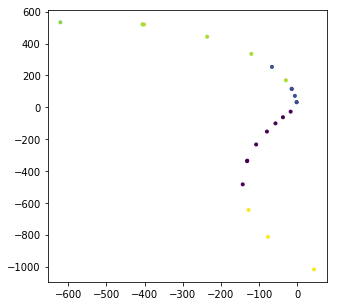

In [48]:
figure = plt.figure(figsize=(5,5))
plt.scatter(hits_test.x, hits_test.y, marker='.', c=hits_test.l)

In [21]:
t = np.array([0,1,2,3,4,5])
# Embedding(6, t)

In [22]:
t.shape

(6,)

In [23]:
model = Sequential()
model.add(Embedding(6, 1, input_length=1))
model.compile(optimizer='adam', loss='categorical_crossentropy')
output_array = model.predict(t)

In [24]:
output_array

array([[[-0.01161207]],

       [[-0.03734656]],

       [[-0.00973426]],

       [[-0.04064435]],

       [[ 0.00465965]],

       [[ 0.04648033]]], dtype=float32)

In [20]:
output_array[0][0][0]

0.047543276

In [27]:
output_array[1][0][0]

-0.037346564

In [69]:
model = Sequential()
# model.add(BatchNormalization(input_shape=(1,2)))
model.add(Bidirectional(LSTM(100, return_sequences=True), input_shape=(1,3)))
# model.add(Bidirectional(LSTM(100, return_sequences=True)))
# model.add(Bidirectional(LSTM(100, return_sequences=True)))
model.add(Bidirectional(LSTM(100)))
# model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))

# model.add(Dense(100000, activation='relu'))

# model.add(Dropout(0.1))
model.add(Dense(100, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

In [ ]:
%%time
model.fit(X_train.reshape(X_train.shape[0], 1, 3), y, batch_size=32, epochs=3000, shuffle=False, verbose=0, 
          callbacks=callbacks_list)

In [ ]:
p = model.predict(X_test.reshape(X_test.shape[0],1,3))

In [ ]:
l = [np.argmax(p[i]) for i in range(len(p))]
# hits_test['l'] = l
sub=create_one_event_submission(0, hits_test, l)
score = score_event(hits_test, sub)
print(score)

In [ ]:
# model.save('../cache/model-3-bilstm-100-particles.hdf5')
model.save('../cache/model-2-bilstm-100-particles.hdf5')

In [ ]:
hits_test = hits_test.sample(frac=1).reset_index(drop=True)
hits_test = hits_test.sample(frac=1).reset_index(drop=True)
hits_test = hits_test.sample(frac=1).reset_index(drop=True)

In [ ]:
hits_test.head()

In [ ]:
X_test = hits_test[['x', 'y', 'z']].values

In [ ]:
p = model.predict(X_test.reshape(X_test.shape[0],1,3))
l = [np.argmax(p[i]) for i in range(len(p))]
hits_test['l'] = l
sub=create_one_event_submission(0, hits_test, l)
score = score_event(hits_test, sub)
print(score)

In [4]:
df_train = pd.read_csv('../cache/hits_6488_nid_z_sorted_ge9_train_100.csv')
df_valid = pd.read_csv('../cache/hits_6488_nid_z_sorted_ge9_valid_25.csv')
df_test = pd.read_csv('../cache/hits_6488_nid_z_sorted_ge9_test_10.csv')

In [7]:
path_to_train = '../data/train'
dataset_submissions = []
dataset_scores = []

mylabels1 = {}
for event_id, hits, cells, particles, truth in load_dataset(path_to_train, skip=10, nevents=1):
    
    truth = pd.merge(truth, particles, how='left', on='particle_id')
    hits = pd.merge(hits, truth, how='left', on='hit_id')

    hits = hits.dropna()
    truth = truth.dropna()

    # Track pattern recognition
    model = Clusterer1()
    labels = model.predict(hits)
    hits['labels'] = labels
    mylabels1[event_id] = labels
    

100%|██████████| 6658/6658 [00:00<00:00, 119324.18it/s]


In [8]:
hits.head()

,hit_id,x,y,z,volume_id,layer_id,module_id,particle_id,tx,ty,...,vz,px,py,pz,q,nhits,x2,y2,z2,labels
0,1,-95.104897,-11.22140,-1502.5,7,2,1,211675367239319552,-95.111397,-11.19950,...,1.224690,-0.655410,-0.105077,-10.50140,1.0,13.0,-0.063170,-0.007453,-15.689510,2498
1,2,-54.898102,-9.61188,-1502.5,7,2,1,689056171826348032,-54.898602,-9.58850,...,3.356830,-0.820384,-0.124732,-22.39010,-1.0,10.0,-0.036513,-0.006393,-26.958797,2981
2,3,-58.008400,3.08322,-1502.5,7,2,1,729583345792450560,-57.987900,3.07949,...,0.698072,-1.156670,0.077993,-29.99840,-1.0,13.0,-0.038579,0.002051,-25.864912,2982
3,4,-97.298401,-8.18418,-1502.5,7,2,1,698059110473531392,-97.308502,-8.20599,...,-5.299510,-0.406458,-0.063105,-6.29345,1.0,11.0,-0.064621,-0.005436,-15.387847,2496
5,6,-81.570198,-10.15620,-1502.5,7,2,1,9017163578867712,-81.572098,-10.16590,...,2.216800,-0.346195,-0.018787,-6.33541,-1.0,15.0,-0.054209,-0.006749,-18.278582,1131


In [9]:
hits.sort_values('particle_id', inplace=True)

In [11]:
pids = list(set(hits.particle_id.values))

In [15]:
max_n = 0
max_n2 = 0
max_pid = 0
max_pid2 = 0
for i, p_id in enumerate(pids):
    h = hits[hits.particle_id == p_id]
    n = h['labels'].nunique()
    if n > max_n:
        max_n2 = max_n
        max_n = n
        max_pid2 = max_pid
        max_pid = p_id 
    elif n > max_n2:
        max_n2 = n
        max_pid2 = p_id
print(max_n, max_n2)
print(max_pid, max_pid2)

15 14
630507796122566656 648521301278851072


In [28]:

epoch = 0
while epoch < 3000:
    str1='../cache/checkpoint/checkpoint-6488-100'
    str2 = '{:2d}.hdf5'.format(epoch)
    filepath = str1 + '-' + str2
    delete_file_if_exists(filepath)
    epoch += 1

In [29]:
epoch = 0
while epoch < 3000:
    str1='../cache/checkpoint/checkpoint-6488-100-1'
    str2 = '{:2d}.hdf5'.format(epoch)
    filepath = str1 + '-' + str2
    delete_file_if_exists(filepath)
    epoch += 1

In [30]:
hits = pd.read_csv('../cache/hits_6488_nid_z_sorted_ge9.csv')
part = list(set(hits.particle_id.values))
part_l = np.random.choice(part, 20)
part_v = list(set(part) - set(part_l))
part_v = np.random.choice(part_v, 6)
part_test = list(set(part) - set(part_l) - set(part_v))
part_test = np.random.choice(part_test, 5)
df_train = hits[hits.particle_id.isin(part_l)]
df_valid = hits[hits.particle_id.isin(part_v)]
df_test = hits[hits.particle_id.isin(part_test)]

df_train.to_csv('../cache/hits_6488_nid_z_sorted_ge9_train_20.csv',index=False)
df_valid.to_csv('../cache/hits_6488_nid_z_sorted_ge9_valid_6.csv',index=False)
df_test.to_csv('../cache/hits_6488_nid_z_sorted_ge9_test_5.csv',index=False)

In [33]:
model = Sequential()
# model.add(BatchNormalization(input_shape=(1,2)))
model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(1,3)))
# model.add(Bidirectional(LSTM(100, return_sequences=True)))
# model.add(Bidirectional(LSTM(100, return_sequences=True)))
model.add(Bidirectional(LSTM(128)))
# model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))

# model.add(Dense(100000, activation='relu'))

# model.add(Dropout(0.1))
model.add(Dense(20, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

In [31]:
str1='../cache/checkpoint/checkpoint-6488-20'
str2 = '{epoch:02d}.hdf5'
filepath = str1 + '-' + str2
checkpoint = ModelCheckpoint(filepath, verbose=0, save_best_only=False)
callbacks_list = [checkpoint]

X_train = df_train[['x', 'y', 'z']].values
X_valid = df_valid[['x', 'y', 'z']].values

y_l = list(range(20))
y_nid = list(set(df_train['nid'].values))
y_map = dict(zip(y_nid, y_l))
y_rev_map = dict(zip(y_l, y_nid))
# print(y)
print(X_train.shape)

y_l_v = list(range(6))
y_nid_v = list(set(df_valid['nid'].values))
y_map_v = dict(zip(y_nid_v, y_l_v))
y_rev_map_v = dict(zip(y_l_v, y_nid_v))

y = [y_map[nid] for nid in df_train.nid.values]
y_v = [y_map_v[nid] for nid in df_valid.nid.values]

(243, 3)


In [34]:
%%time
model.fit(X_train.reshape(X_train.shape[0], 1, 3), y, batch_size=32, epochs=3000, shuffle=False, verbose=0,
          callbacks=callbacks_list)
#          validation_data=[X_valid.reshape(X_valid.shape[0],1,3), y_v])

CPU times: user 17min 12s, sys: 2min 15s, total: 19min 27s
Wall time: 4min 32s


In [35]:
path_to_train = "../data/train"
dataset_submissions = []
dataset_scores = []

mylabels1 = {}
for event_id, hits, cells, particles, truth in load_dataset(path_to_train, skip=10, nevents=1):
    
    truth = pd.merge(truth, particles, how='left', on='particle_id')
    hits = pd.merge(hits, truth, how='left', on='hit_id')

    hits = hits.dropna()
    truth = truth.dropna()

    # Track pattern recognition
    model1 = Clusterer1()
    labs = model1.predict(hits)
    hits['labels'] = labs
    mylabels1[event_id] = labs
    
    all_hits = pd.DataFrame()
    prev_p_len = 0
    for i, label in tqdm(enumerate(list(set(labs)))):
#         print(i)
#         print(label)
        myhits = hits[hits['labels'] == label]
        X_test = myhits[['x2', 'y2', 'z2']].values

        p = model.predict(X_test.reshape(X_test.shape[0],1,3))    
        p = [np.argmax(p[j]) + 1 + (i * prev_p_len) for j in range(len(p))]
        prev_p_len = len(p)
        myhits['labels1'] = p
        all_hits = all_hits.append(myhits)
    all_hits.sort_values('hit_id', inplace=True)
    # Prepare submission for an event
    one_submission = create_one_event_submission(event_id, all_hits, all_hits['labels1'].values)
#     dataset_submissions.append(one_submission)

    # Score for the event
    score = score_event(truth, one_submission)
    dataset_scores.append(score)

    print("Score for event %d: %.9f" % (event_id, score))
print('Mean score: %.9f' % (np.mean(dataset_scores)))

100%|██████████| 6658/6658 [00:00<00:00, 165318.94it/s]
6657it [11:27,  9.69it/s]


Score for event 1010: 0.237230727
Mean score: 0.237230727


In [36]:
path_to_train = "../data/train"
dataset_submissions = []
dataset_scores = []

mylabels1 = {}
for event_id, hits, cells, particles, truth in load_dataset(path_to_train, skip=10, nevents=1):
    
    truth = pd.merge(truth, particles, how='left', on='particle_id')
    hits = pd.merge(hits, truth, how='left', on='hit_id')

    hits = hits.dropna()
    truth = truth.dropna()

    # Track pattern recognition
    model1 = Clusterer1()
    labs = model1.predict(hits)
    hits['labels'] = labs
    mylabels1[event_id] = labs
    
    all_hits = pd.DataFrame()
    prev_p_len = 0
    for i, label in tqdm(enumerate(list(set(labs)))):
#         print(i)
#         print(label)
        myhits = hits[hits['labels'] == label]
        X_test = myhits[['x2', 'y2', 'z2']].values

        p = model.predict(X_test.reshape(X_test.shape[0],1,3))    
        p = [np.argmax(p[j]) + 1 + (i * prev_p_len) for j in range(len(p))]
        prev_p_len = len(p)
        if prev_p_len < 100:
            prev_p_len = 100
        myhits['labels1'] = p
        all_hits = all_hits.append(myhits)
    all_hits.sort_values('hit_id', inplace=True)
    # Prepare submission for an event
    one_submission = create_one_event_submission(event_id, all_hits, all_hits['labels1'].values)
#     dataset_submissions.append(one_submission)

    # Score for the event
    score = score_event(truth, one_submission)
    dataset_scores.append(score)

    print("Score for event %d: %.9f" % (event_id, score))
print('Mean score: %.9f' % (np.mean(dataset_scores)))

100%|██████████| 6658/6658 [00:00<00:00, 144898.33it/s]
6657it [11:26,  9.70it/s]


Score for event 1010: 0.255072055
Mean score: 0.255072055


In [37]:
path_to_train = "../data/train"
dataset_submissions = []
dataset_scores = []

mylabels1 = {}
for event_id, hits, cells, particles, truth in load_dataset(path_to_train, skip=10, nevents=1):
    
    truth = pd.merge(truth, particles, how='left', on='particle_id')
    hits = pd.merge(hits, truth, how='left', on='hit_id')

    hits = hits.dropna()
    truth = truth.dropna()

    # Track pattern recognition
    model1 = Clusterer1()
    labs = model1.predict(hits)
    hits['labels'] = labs
    mylabels1[event_id] = labs
    
    all_hits = pd.DataFrame()
    prev_p_len = 0
    for i, label in tqdm(enumerate(list(set(labs)))):
#         print(i)
#         print(label)
        myhits = hits[hits['labels'] == label]
        X_test = myhits[['x2', 'y2', 'z2']].values

        p = model.predict(X_test.reshape(X_test.shape[0],1,3))    
        p = [np.argmax(p[j]) + 1 + (i * prev_p_len) for j in range(len(p))]
        prev_p_len = len(p)
        if prev_p_len < 1000:
            prev_p_len = 1000
        myhits['labels1'] = p
        all_hits = all_hits.append(myhits)
    all_hits.sort_values('hit_id', inplace=True)
    # Prepare submission for an event
    one_submission = create_one_event_submission(event_id, all_hits, all_hits['labels1'].values)
#     dataset_submissions.append(one_submission)

    # Score for the event
    score = score_event(truth, one_submission)
    dataset_scores.append(score)

    print("Score for event %d: %.9f" % (event_id, score))
print('Mean score: %.9f' % (np.mean(dataset_scores)))

100%|██████████| 6658/6658 [00:00<00:00, 260503.14it/s]
6657it [11:03, 10.03it/s]


Score for event 1010: 0.255072055
Mean score: 0.255072055


In [38]:
path_to_test = "../data/test"
test_dataset_submissions = []

create_submission = True # True for submission 
if create_submission:
    for event_id, hits, cells in load_dataset(path_to_test, parts=['hits', 'cells']):

        # Track pattern recognition 
        model1 = Clusterer1()
        labs = model1.predict(hits)
        hits['labels'] = labs
        
        all_hits = pd.DataFrame()
        prev_p_len = 0
        for i, label in tqdm(enumerate(list(set(labs)))):
            myhits = hits[hits['labels'] == label]
            X_test = myhits[['x2', 'y2', 'z2']].values

            p = model.predict(X_test.reshape(X_test.shape[0],1,3))    
            p = [np.argmax(p[j]) + 1 + (i * prev_p_len) for j in range(len(p))]
            prev_p_len = len(p)
            if prev_p_len < 100:
                prev_p_len = 100
            myhits['labels1'] = p
            all_hits = all_hits.append(myhits)
        all_hits.sort_values('hit_id', inplace=True)
    
        # Prepare submission for an event
#         one_submission = create_one_event_submission(event_id, hits, labels)
        one_submission = create_one_event_submission(event_id, all_hits, all_hits['labels1'].values)
        test_dataset_submissions.append(one_submission)
        
        print('Event ID: ', event_id)

    # Create submission file
    submission = pd.concat(test_dataset_submissions, axis=0)
    submission.to_csv('submission-004.csv', index=False)

100%|██████████| 9157/9157 [00:00<00:00, 164340.69it/s]
9156it [24:35,  6.20it/s]


Event ID:  0


100%|██████████| 9453/9453 [00:00<00:00, 215110.60it/s]
9453it [18:00,  8.75it/s]


Event ID:  1


100%|██████████| 8113/8113 [00:00<00:00, 160816.97it/s]
8112it [13:13, 10.22it/s]


Event ID:  2


100%|██████████| 8357/8357 [00:00<00:00, 246345.76it/s]
8357it [12:42, 10.97it/s]


Event ID:  3


100%|██████████| 9150/9150 [00:00<00:00, 157987.63it/s]
9149it [13:54, 10.97it/s]


Event ID:  4


100%|██████████| 8229/8229 [00:00<00:00, 268812.03it/s]
8229it [13:05, 10.48it/s]


Event ID:  5


100%|██████████| 8255/8255 [00:00<00:00, 269187.55it/s]
8255it [12:34, 10.95it/s]


Event ID:  6


100%|██████████| 8944/8944 [00:00<00:00, 266180.30it/s]
8944it [14:31, 10.26it/s]


Event ID:  7


100%|██████████| 8901/8901 [00:00<00:00, 212986.20it/s]
8901it [15:24,  9.63it/s]


Event ID:  8


100%|██████████| 8823/8823 [00:00<00:00, 265280.35it/s]
8822it [13:34, 10.83it/s]


Event ID:  9


100%|██████████| 9007/9007 [00:00<00:00, 254711.84it/s]
9005it [13:36, 11.03it/s]


Event ID:  10


100%|██████████| 8316/8316 [00:00<00:00, 276057.24it/s]
8316it [12:32, 11.05it/s]


Event ID:  11


100%|██████████| 7944/7944 [00:00<00:00, 172769.07it/s]
7944it [11:59, 11.04it/s]


Event ID:  12


100%|██████████| 9698/9698 [00:00<00:00, 254062.11it/s]
9697it [14:40, 11.01it/s]


Event ID:  13


100%|██████████| 7890/7890 [00:00<00:00, 265944.41it/s]
7890it [11:54, 11.04it/s]


Event ID:  14


100%|██████████| 6916/6916 [00:00<00:00, 233949.02it/s]
6916it [10:31, 10.95it/s]


Event ID:  15


100%|██████████| 7456/7456 [00:00<00:00, 273805.81it/s]
7455it [11:21, 10.94it/s]


Event ID:  16


100%|██████████| 10107/10107 [00:00<00:00, 217092.30it/s]
10107it [15:27, 10.89it/s]


Event ID:  17


100%|██████████| 7470/7470 [00:00<00:00, 263495.43it/s]
7468it [11:21, 10.95it/s]


Event ID:  18


100%|██████████| 8040/8040 [00:00<00:00, 264680.94it/s]
8040it [12:28, 10.74it/s]


Event ID:  19


100%|██████████| 6163/6163 [00:00<00:00, 168743.61it/s]
6163it [09:26, 10.88it/s]


Event ID:  20


100%|██████████| 8153/8153 [00:00<00:00, 259038.27it/s]
8153it [14:00,  9.70it/s]


Event ID:  21


100%|██████████| 9227/9227 [00:00<00:00, 243815.55it/s]
9227it [16:26,  9.35it/s]


Event ID:  22


100%|██████████| 8998/8998 [00:00<00:00, 162554.10it/s]
8998it [16:00,  9.37it/s]


Event ID:  23


100%|██████████| 9000/9000 [00:00<00:00, 152003.03it/s]
9000it [16:01,  9.36it/s]


Event ID:  24


100%|██████████| 8443/8443 [00:00<00:00, 257661.70it/s]
8443it [14:58,  9.39it/s]


Event ID:  25


100%|██████████| 7302/7302 [00:00<00:00, 266023.97it/s]
7302it [12:59,  9.37it/s]


Event ID:  26


100%|██████████| 7709/7709 [00:00<00:00, 267897.51it/s]
7707it [13:40,  9.40it/s]


Event ID:  27


100%|██████████| 8308/8308 [00:00<00:00, 229312.17it/s]
8308it [14:46,  9.38it/s]


Event ID:  28


100%|██████████| 6796/6796 [00:00<00:00, 281982.57it/s]
6795it [12:02,  9.40it/s]


Event ID:  29


100%|██████████| 8659/8659 [00:00<00:00, 147270.31it/s]
8658it [15:27,  9.34it/s]


Event ID:  30


100%|██████████| 7991/7991 [00:00<00:00, 160103.39it/s]
7991it [14:15,  9.35it/s]


Event ID:  31


100%|██████████| 6479/6479 [00:00<00:00, 282102.10it/s]
6477it [11:27,  9.42it/s]


Event ID:  32


100%|██████████| 6589/6589 [00:00<00:00, 159100.70it/s]
6589it [11:39,  9.42it/s]


Event ID:  33


100%|██████████| 9591/9591 [00:00<00:00, 216067.00it/s]
9591it [17:07,  9.34it/s]


Event ID:  34


100%|██████████| 7956/7956 [00:00<00:00, 255639.35it/s]
7956it [14:11,  9.34it/s]


Event ID:  35


100%|██████████| 8567/8567 [00:00<00:00, 192218.74it/s]
8566it [15:14,  9.37it/s]


Event ID:  36


100%|██████████| 9506/9506 [00:00<00:00, 159243.44it/s]
9506it [16:57,  9.34it/s]


Event ID:  37


100%|██████████| 8206/8206 [00:00<00:00, 150639.03it/s]
8206it [14:36,  9.36it/s]


Event ID:  38


100%|██████████| 9316/9316 [00:00<00:00, 255016.49it/s]
9316it [16:39,  9.32it/s]


Event ID:  39


100%|██████████| 9048/9048 [00:00<00:00, 195094.94it/s]
9048it [16:08,  9.35it/s]


Event ID:  40


100%|██████████| 8496/8496 [00:00<00:00, 152441.85it/s]
8496it [15:05,  9.39it/s]


Event ID:  41


100%|██████████| 8402/8402 [00:00<00:00, 160661.15it/s]
8401it [14:56,  9.37it/s]


Event ID:  42


100%|██████████| 8419/8419 [00:00<00:00, 159229.49it/s]
8418it [14:57,  9.38it/s]


Event ID:  43


100%|██████████| 10661/10661 [00:00<00:00, 189219.79it/s]
10660it [19:04,  9.31it/s]


Event ID:  44


100%|██████████| 7579/7579 [00:00<00:00, 164987.47it/s]
7579it [13:27,  9.39it/s]


Event ID:  45


100%|██████████| 7336/7336 [00:00<00:00, 149546.85it/s]
7336it [12:59,  9.41it/s]


Event ID:  46


100%|██████████| 6873/6873 [00:00<00:00, 154394.45it/s]
6873it [12:10,  9.41it/s]


Event ID:  47


100%|██████████| 7994/7994 [00:00<00:00, 153598.94it/s]
7994it [14:15,  9.35it/s]


Event ID:  48


100%|██████████| 9157/9157 [00:00<00:00, 221725.21it/s]
9157it [16:12,  9.41it/s]


Event ID:  49


100%|██████████| 9177/9177 [00:00<00:00, 173294.47it/s]
9177it [16:15,  9.40it/s]


Event ID:  50


100%|██████████| 8645/8645 [00:00<00:00, 159684.67it/s]
8644it [15:18,  9.41it/s]


Event ID:  51


100%|██████████| 8763/8763 [00:00<00:00, 258999.97it/s]
8763it [15:31,  9.41it/s]


Event ID:  52


100%|██████████| 8378/8378 [00:00<00:00, 236006.01it/s]
8377it [14:48,  9.43it/s]


Event ID:  53


100%|██████████| 9088/9088 [00:00<00:00, 260211.31it/s]
9088it [16:07,  9.40it/s]


Event ID:  54


100%|██████████| 7537/7537 [00:00<00:00, 255124.44it/s]
7537it [13:18,  9.44it/s]


Event ID:  55


100%|██████████| 8593/8593 [00:00<00:00, 157755.00it/s]
8593it [15:13,  9.41it/s]


Event ID:  56


100%|██████████| 9441/9441 [00:00<00:00, 176258.56it/s]
9441it [16:45,  9.39it/s]


Event ID:  57


100%|██████████| 9334/9334 [00:00<00:00, 157194.62it/s]
9334it [16:35,  9.38it/s]


Event ID:  58


100%|██████████| 8623/8623 [00:00<00:00, 234934.64it/s]
8622it [15:15,  9.42it/s]


Event ID:  59


100%|██████████| 7833/7833 [00:00<00:00, 267409.92it/s]
7833it [13:51,  9.42it/s]


Event ID:  60


100%|██████████| 8078/8078 [00:00<00:00, 233028.11it/s]
8077it [14:17,  9.42it/s]


Event ID:  61


100%|██████████| 8728/8728 [00:00<00:00, 259350.81it/s]
8727it [15:27,  9.41it/s]


Event ID:  62


100%|██████████| 9198/9198 [00:00<00:00, 160275.89it/s]
9198it [16:18,  9.40it/s]


Event ID:  63


100%|██████████| 8812/8812 [00:00<00:00, 233563.19it/s]
8812it [15:36,  9.41it/s]


Event ID:  64


100%|██████████| 7272/7272 [00:00<00:00, 249466.15it/s]
7272it [12:53,  9.40it/s]


Event ID:  65


100%|██████████| 8461/8461 [00:00<00:00, 154121.45it/s]
8461it [14:59,  9.41it/s]


Event ID:  66


100%|██████████| 9663/9663 [00:00<00:00, 231474.47it/s]
9663it [17:10,  9.38it/s]


Event ID:  67


100%|██████████| 8308/8308 [00:00<00:00, 153979.95it/s]
8308it [14:42,  9.41it/s]


Event ID:  68


100%|██████████| 7732/7732 [00:00<00:00, 160985.45it/s]
7731it [13:40,  9.42it/s]


Event ID:  69


100%|██████████| 7810/7810 [00:00<00:00, 157950.51it/s]
7809it [13:49,  9.41it/s]


Event ID:  70


100%|██████████| 8950/8950 [00:00<00:00, 255180.01it/s]
8950it [15:56,  9.35it/s]


Event ID:  71


100%|██████████| 8135/8135 [00:00<00:00, 160402.52it/s]
8135it [14:25,  9.40it/s]


Event ID:  72


100%|██████████| 8559/8559 [00:00<00:00, 276945.40it/s]
8559it [15:11,  9.39it/s]


Event ID:  73


100%|██████████| 8768/8768 [00:00<00:00, 143697.01it/s]
8767it [15:35,  9.37it/s]


Event ID:  74


100%|██████████| 7591/7591 [00:00<00:00, 272523.85it/s]
7591it [13:27,  9.40it/s]


Event ID:  75


100%|██████████| 7947/7947 [00:00<00:00, 202670.08it/s]
7947it [14:04,  9.41it/s]


Event ID:  76


100%|██████████| 7018/7018 [00:00<00:00, 264136.41it/s]
7017it [12:23,  9.44it/s]


Event ID:  77


100%|██████████| 8549/8549 [00:00<00:00, 155337.19it/s]
8549it [15:14,  9.35it/s]


Event ID:  78


100%|██████████| 7119/7119 [00:00<00:00, 278784.84it/s]
7119it [12:37,  9.40it/s]


Event ID:  79


100%|██████████| 9848/9848 [00:00<00:00, 152467.22it/s]
9848it [17:32,  9.36it/s]


Event ID:  80


100%|██████████| 8219/8219 [00:00<00:00, 228263.14it/s]
8219it [14:34,  9.40it/s]


Event ID:  81


100%|██████████| 8218/8218 [00:00<00:00, 158695.36it/s]
8218it [14:34,  9.39it/s]


Event ID:  82


100%|██████████| 9638/9638 [00:00<00:00, 212183.11it/s]
9638it [17:10,  9.36it/s]


Event ID:  83


100%|██████████| 7481/7481 [00:00<00:00, 167862.81it/s]
7480it [13:14,  9.41it/s]


Event ID:  84


100%|██████████| 8657/8657 [00:00<00:00, 159643.39it/s]
8657it [15:21,  9.39it/s]


Event ID:  85


100%|██████████| 9301/9301 [00:00<00:00, 161590.68it/s]
9301it [16:32,  9.37it/s]


Event ID:  86


100%|██████████| 9196/9196 [00:00<00:00, 161260.03it/s]
9196it [16:25,  9.33it/s]


Event ID:  87


100%|██████████| 9134/9134 [00:00<00:00, 156742.85it/s]
9134it [16:15,  9.36it/s]


Event ID:  88


100%|██████████| 9138/9138 [00:00<00:00, 265224.21it/s]
9138it [16:18,  9.34it/s]


Event ID:  89


100%|██████████| 8474/8474 [00:00<00:00, 249298.82it/s]
8474it [15:03,  9.38it/s]


Event ID:  90


100%|██████████| 7941/7941 [00:00<00:00, 163871.12it/s]
7941it [14:05,  9.39it/s]


Event ID:  91


100%|██████████| 7641/7641 [00:00<00:00, 159138.96it/s]
7641it [13:32,  9.40it/s]


Event ID:  92


100%|██████████| 10299/10299 [00:00<00:00, 262169.46it/s]
10299it [18:22,  9.34it/s]


Event ID:  93


100%|██████████| 7418/7418 [00:00<00:00, 263420.17it/s]
7418it [13:09,  9.40it/s]


Event ID:  94


100%|██████████| 8822/8822 [00:00<00:00, 155832.64it/s]
8822it [15:42,  9.36it/s]


Event ID:  95


100%|██████████| 8015/8015 [00:00<00:00, 269190.74it/s]
8015it [14:13,  9.39it/s]


Event ID:  96


100%|██████████| 8556/8556 [00:00<00:00, 207927.79it/s]
8556it [15:16,  9.34it/s]


Event ID:  97


100%|██████████| 8935/8935 [00:00<00:00, 164917.89it/s]
8935it [15:54,  9.36it/s]


Event ID:  98


100%|██████████| 8877/8877 [00:00<00:00, 265916.54it/s]
8876it [15:49,  9.35it/s]


Event ID:  99


100%|██████████| 9874/9874 [00:00<00:00, 270222.42it/s]
9874it [17:37,  9.34it/s]


Event ID:  100


100%|██████████| 9802/9802 [00:00<00:00, 180736.03it/s]
9801it [17:29,  9.34it/s]


Event ID:  101


100%|██████████| 8692/8692 [00:00<00:00, 151336.20it/s]
8692it [15:28,  9.36it/s]


Event ID:  102


100%|██████████| 7880/7880 [00:00<00:00, 154824.29it/s]
7879it [14:00,  9.38it/s]


Event ID:  103


100%|██████████| 9110/9110 [00:00<00:00, 271739.52it/s]
9109it [16:14,  9.34it/s]


Event ID:  104


100%|██████████| 7064/7064 [00:00<00:00, 155989.89it/s]
7064it [12:32,  9.39it/s]


Event ID:  105


100%|██████████| 8755/8755 [00:00<00:00, 198378.94it/s]
8755it [15:35,  9.36it/s]


Event ID:  106


100%|██████████| 9835/9835 [00:00<00:00, 222644.90it/s]
9835it [17:34,  9.33it/s]


Event ID:  107


100%|██████████| 8687/8687 [00:00<00:00, 255767.84it/s]
8687it [15:27,  9.36it/s]


Event ID:  108


100%|██████████| 8991/8991 [00:00<00:00, 231733.92it/s]
8991it [16:02,  9.34it/s]


Event ID:  109


100%|██████████| 8767/8767 [00:00<00:00, 149157.35it/s]
8765it [15:35,  9.37it/s]


Event ID:  110


100%|██████████| 8998/8998 [00:00<00:00, 155923.50it/s]
8995it [16:03,  9.34it/s]


Event ID:  111


100%|██████████| 8354/8354 [00:00<00:00, 251875.93it/s]
8354it [14:51,  9.37it/s]


Event ID:  112


100%|██████████| 9758/9758 [00:00<00:00, 208293.56it/s]
9758it [17:24,  9.34it/s]


Event ID:  113


100%|██████████| 7465/7465 [00:00<00:00, 150365.60it/s]
7465it [13:19,  9.34it/s]


Event ID:  114


100%|██████████| 7621/7621 [00:00<00:00, 163523.68it/s]
7620it [13:33,  9.37it/s]


Event ID:  115


100%|██████████| 9102/9102 [00:00<00:00, 199248.21it/s]
9102it [16:13,  9.35it/s]


Event ID:  116


100%|██████████| 8958/8958 [00:00<00:00, 261649.28it/s]
8958it [15:58,  9.35it/s]


Event ID:  117


100%|██████████| 8096/8096 [00:00<00:00, 159215.88it/s]
8096it [14:24,  9.36it/s]


Event ID:  118


100%|██████████| 6646/6646 [00:00<00:00, 288245.36it/s]
6646it [11:46,  9.41it/s]


Event ID:  119


100%|██████████| 8125/8125 [00:00<00:00, 252982.15it/s]
8125it [14:31,  9.32it/s]


Event ID:  120


100%|██████████| 8981/8981 [00:00<00:00, 149840.67it/s]
8981it [15:59,  9.36it/s]


Event ID:  121


100%|██████████| 6998/6998 [00:00<00:00, 262958.94it/s]
6998it [12:26,  9.38it/s]


Event ID:  122


100%|██████████| 7885/7885 [00:00<00:00, 267311.83it/s]
7885it [14:02,  9.36it/s]


Event ID:  123


100%|██████████| 8288/8288 [00:00<00:00, 152007.94it/s]
8288it [14:46,  9.35it/s]


Event ID:  124


In [ ]:
model_100 = load_model('../cache/checkpoint/checkpoint-6488-100-1-3000.hdf5')

In [ ]:
path_to_train = "../data/train"
dataset_submissions = []
dataset_scores = []

mylabels1 = {}
for event_id, hits, cells, particles, truth in load_dataset(path_to_train, skip=10, nevents=1):
    
    truth = pd.merge(truth, particles, how='left', on='particle_id')
    hits = pd.merge(hits, truth, how='left', on='hit_id')

    hits = hits.dropna()
    truth = truth.dropna()

    # Track pattern recognition
    model1 = Clusterer1()
    labs = model1.predict(hits)
    hits['labels'] = labs
    mylabels1[event_id] = labs
    
    all_hits = pd.DataFrame()
    prev_p_len = 0
    for i, label in tqdm(enumerate(list(set(labs)))):
#         print(i)
#         print(label)
        myhits = hits[hits['labels'] == label]
        X_test = myhits[['x2', 'y2', 'z2']].values

        p = model.predict(X_test.reshape(X_test.shape[0],1,3))    
        p = [np.argmax(p[j]) + 1 + (i * prev_p_len) for j in range(len(p))]
        prev_p_len = len(p)
        if prev_p_len < 100:
            prev_p_len = 100
        num_instances = [p.count(j) for j in p]
        myhits['labels1'] = p
        myhits['num_label_instances'] = num_instances
        all_hits = all_hits.append(myhits)
        all_hits_new = all_hits[all_hits.num_label_instances <= 3]
        print(all_hits_new.shape)
    all_hits.sort_values('hit_id', inplace=True)
    # Prepare submission for an event
    one_submission = create_one_event_submission(event_id, all_hits, all_hits['labels1'].values)
#     dataset_submissions.append(one_submission)

    # Score for the event
    score = score_event(all_hits, one_submission)
    dataset_scores.append(score)

    print("Score for event %d: %.9f" % (event_id, score))
print('Mean score: %.9f' % (np.mean(dataset_scores)))